# Loading data into a dataframe

In [0]:
display(dbutils.fs.ls("/Volumes/databricksmaster_workspace/salesdb/volume_products"))

path,name,size,modificationTime
dbfs:/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv,products.csv,14372,1758195260000


In [0]:
#%pyspark

df = spark.read.load('/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv',
    format='csv',
    header=True);
display(df.limit(10));    




ProductID,ProductName,Category,ListPrice
771,"Mountain-100 Silver, 38",Mountain Bikes,3399.9900
772,"Mountain-100 Silver, 42",Mountain Bikes,3399.9900
773,"Mountain-100 Silver, 44",Mountain Bikes,3399.9900
774,"Mountain-100 Silver, 48",Mountain Bikes,3399.9900
775,"Mountain-100 Black, 38",Mountain Bikes,3374.9900
776,"Mountain-100 Black, 42",Mountain Bikes,3374.9900
777,"Mountain-100 Black, 44",Mountain Bikes,3374.9900
778,"Mountain-100 Black, 48",Mountain Bikes,3374.9900
779,"Mountain-200 Silver, 38",Mountain Bikes,2319.9900
780,"Mountain-200 Silver, 42",Mountain Bikes,2319.9900


In [0]:
#%spark
file_path = "/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv"

df = spark.read.format("csv").option("header", "true").load(file_path)
display(df.limit(10))

ProductID,ProductName,Category,ListPrice
771,"Mountain-100 Silver, 38",Mountain Bikes,3399.9900
772,"Mountain-100 Silver, 42",Mountain Bikes,3399.9900
773,"Mountain-100 Silver, 44",Mountain Bikes,3399.9900
774,"Mountain-100 Silver, 48",Mountain Bikes,3399.9900
775,"Mountain-100 Black, 38",Mountain Bikes,3374.9900
776,"Mountain-100 Black, 42",Mountain Bikes,3374.9900
777,"Mountain-100 Black, 44",Mountain Bikes,3374.9900
778,"Mountain-100 Black, 48",Mountain Bikes,3374.9900
779,"Mountain-200 Silver, 38",Mountain Bikes,2319.9900
780,"Mountain-200 Silver, 42",Mountain Bikes,2319.9900


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

productSchema = StructType([
    StructField("ProductID", IntegerType()),
    StructField("ProductName", StringType()),
    StructField("Category", StringType()),
    StructField("ListPrice", FloatType())
    ])

df = spark.read.load('/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv',
    format='csv',
    schema=productSchema,
    header=False)
display(df.limit(10))

ProductID,ProductName,Category,ListPrice
null,ProductName,Category,null
771,"Mountain-100 Silver, 38",Mountain Bikes,3399.99
772,"Mountain-100 Silver, 42",Mountain Bikes,3399.99
773,"Mountain-100 Silver, 44",Mountain Bikes,3399.99
774,"Mountain-100 Silver, 48",Mountain Bikes,3399.99
775,"Mountain-100 Black, 38",Mountain Bikes,3374.99
776,"Mountain-100 Black, 42",Mountain Bikes,3374.99
777,"Mountain-100 Black, 44",Mountain Bikes,3374.99
778,"Mountain-100 Black, 48",Mountain Bikes,3374.99
779,"Mountain-200 Silver, 38",Mountain Bikes,2319.99


In [0]:
pricelist_df = df.select("ProductID", "ListPrice")
display(pricelist_df.limit(10))

ProductID,ListPrice
null,null
771,3399.99
772,3399.99
773,3399.99
774,3399.99
775,3374.99
776,3374.99
777,3374.99
778,3374.99
779,2319.99


In [0]:
bikes_df = df.select("ProductName", "ListPrice").where((df["Category"]=="Mountain Bikes") | (df["Category"]=="Road Bikes"))
display(bikes_df.limit(10))

ProductName,ListPrice
"Mountain-100 Silver, 38",3399.99
"Mountain-100 Silver, 42",3399.99
"Mountain-100 Silver, 44",3399.99
"Mountain-100 Silver, 48",3399.99
"Mountain-100 Black, 38",3374.99
"Mountain-100 Black, 42",3374.99
"Mountain-100 Black, 44",3374.99
"Mountain-100 Black, 48",3374.99
"Mountain-200 Silver, 38",2319.99
"Mountain-200 Silver, 42",2319.99


In [0]:
counts_df = df.select("ProductID", "Category").groupBy("Category").count()
display(counts_df.limit(10))

Category,count
Headsets,3
Wheels,14
Bottom Brackets,3
Touring Frames,18
Mountain Bikes,32
Pedals,7
Derailleurs,2
Chains,1
Pumps,2
Hydration Packs,1


**Note**
Spark DataFrames are declarative and immutable. Each transformation (like select, filter, or groupBy) creates a new DataFrame that represents what you want, not how it runs. This makes code reusable, optimizable, and free of side effects. But none of these transformations actually execute until you trigger an action (for example, display, collect, write), at which point Spark runs the full optimized plan.

# Using SQL expressions in Spark


You can create an empty table by using the **spark.catalog.createTable** method. Tables are metadata structures that store their underlying data in the storage location associated with the catalog. Deleting a table also deletes its underlying data.

You can save a dataframe as a table by using its **saveAsTable** method.

You can create an external table by using the **spark.catalog.createExternalTable** method. External tables define metadata in the catalog but get their underlying data from an external storage location; typically a folder in a data lake. Deleting an external table doesn't delete the underlying data.

In [0]:
%sql
SELECT *
FROM csv.`/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv`
where _c0 < 710

_c0,_c1,_c2,_c3
680,"HL Road Frame - Black, 58",Road Frames,1431.5000
706,"HL Road Frame - Red, 58",Road Frames,1431.5000
709,"Mountain Bike Socks, M",Socks,9.5000
707,"Sport-100 Helmet, Red",Helmets,34.9900
708,"Sport-100 Helmet, Black",Helmets,34.9900


In [0]:
#bikes_df = spark.sql("SELECT ProductID, ProductName, ListPrice \
#                      FROM  `/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv` \
#                      WHERE Category IN ('Mountain Bikes', 'Road Bikes')")
# You cannot use the FROM clause in Spark SQL to directly query a CSV file on a Unity Catalog volume as if it were a table. Instead, you should use the csv data source syntax in Spark SQL, or use PySpark DataFrame APIs to read the CSV file.



#Here is the correct way to read the CSV file from a Unity Catalog volume using PySpark DataFrame API, and then filter and select the desired columns:

bikes_df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv")
    .filter("Category IN ('Mountain Bikes', 'Road Bikes') ")
    .select("ProductID", "ProductName", "ListPrice")
)

display(bikes_df.limit(10))

ProductID,ProductName,ListPrice
771,"Mountain-100 Silver, 38",3399.99
772,"Mountain-100 Silver, 42",3399.99
773,"Mountain-100 Silver, 44",3399.99
774,"Mountain-100 Silver, 48",3399.99
775,"Mountain-100 Black, 38",3374.99
776,"Mountain-100 Black, 42",3374.99
777,"Mountain-100 Black, 44",3374.99
778,"Mountain-100 Black, 48",3374.99
779,"Mountain-200 Silver, 38",2319.99
780,"Mountain-200 Silver, 42",2319.99


In [0]:
bikes_df = spark.sql(
    """
    SELECT id, name, marks
    FROM databricksmaster_workspace.salesdb.exttable
    """
)
display(bikes_df)

id,name,marks
1,aa,30
2,aa,33
3,aa,35
4,aa,40
5,aa,30
6,aa,33
7,aa,35
8,aa,40


In [0]:
%sql
SELECT Category, COUNT(ProductID) AS ProductCount
FROM csv.`/Volumes/databricksmaster_workspace/salesdb/volume_products/products.csv`
--OPTIONS (header="true")
WITH (  header = "true")
GROUP BY Category
ORDER BY Category

Category,ProductCount
Bib-Shorts,3
Bike Racks,1
Bike Stands,1
Bottles and Cages,3
Bottom Brackets,3
Brakes,2
Caps,1
Chains,1
Cleaners,1
Cranksets,3


# Using graphics packages in code

In [0]:
bikes_df = spark.sql("SELECT ProductID, ProductName, ListPrice \
                      FROM  databricksmaster_workspace.salesdb.products \
                      WHERE Category IN ('Mountain Bikes', 'Road Bikes')")

display(bikes_df.limit(10))

ProductID,ProductName,ListPrice
771,"Mountain-100 Silver, 38",3399.99
772,"Mountain-100 Silver, 42",3399.99
773,"Mountain-100 Silver, 44",3399.99
774,"Mountain-100 Silver, 48",3399.99
775,"Mountain-100 Black, 38",3374.99
776,"Mountain-100 Black, 42",3374.99
777,"Mountain-100 Black, 44",3374.99
778,"Mountain-100 Black, 48",3374.99
779,"Mountain-200 Silver, 38",2319.99
780,"Mountain-200 Silver, 42",2319.99


<Figure size 640x480 with 0 Axes>

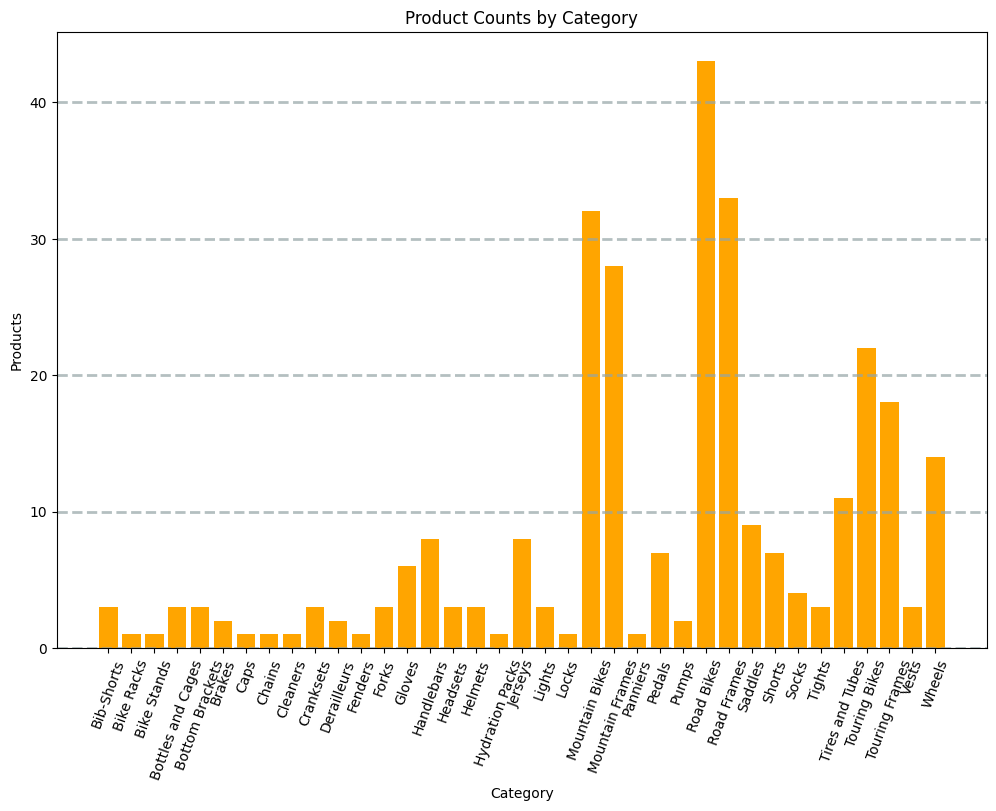

In [0]:
from matplotlib import pyplot as plt

# Get the data as a Pandas dataframe
data = spark.sql("SELECT Category, COUNT(ProductID) AS ProductCount \
                  FROM databricksmaster_workspace.salesdb.products \
                  GROUP BY Category \
                  ORDER BY Category").toPandas()

# Clear the plot area
plt.clf()

# Create a Figure
fig = plt.figure(figsize=(12,8))

# Create a bar plot of product counts by category
plt.bar(x=data['Category'], height=data['ProductCount'], color='orange')

# Customize the chart
plt.title('Product Counts by Category')
plt.xlabel('Category')
plt.ylabel('Products')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=70)

# Show the plot area
plt.show()

# Exercise

In [0]:
%sh

pwd
rm -r dbfs/spark_lab
mkdir dbfs/spark_lab
cd dbfs/spark_lab
pwd

/Workspace/MicrosoftLearnings
/Workspace/MicrosoftLearnings/dbfs/spark_lab


In [0]:
%sh

pwd

wget -O dbfs/spark_lab/2019.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2019_edited.csv
wget -O dbfs/spark_lab/2020.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2020_edited.csv
wget -O dbfs/spark_lab/2021.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2021_edited.csv

/Workspace/MicrosoftLearnings


--2025-09-19 06:27:26--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2019_edited.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123385 (120K) [text/plain]
Saving to: ‘dbfs/spark_lab/2019.csv’

     0K .......... .......... .......... .......... .......... 41% 2.73M 0s
    50K .......... .......... .......... .......... .......... 82% 29.5M 0s
   100K .......... ..........                                 100% 38.6M=0.02s

2025-09-19 06:27:26 (5.87 MB/s) - ‘dbfs/spark_lab/2019.csv’ saved [123385/123385]

--2025-09-19 06:27:26--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2020_edited.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

orderSchema = StructType([
     StructField("SalesOrderNumber", StringType()),
     StructField("SalesOrderLineNumber", IntegerType()),
     StructField("OrderDate", DateType()),
     StructField("CustomerName", StringType()),
     StructField("Email", StringType()),
     StructField("Item", StringType()),
     StructField("Quantity", IntegerType()),
     StructField("UnitPrice", FloatType()),
     StructField("Tax", FloatType())
])

# The path is corrected to use the Workspace path, as inferred from your original code.
# The 'dbfs:/' prefix is only used for files in the Databricks File System (DBFS) root.
#df = spark.read.format("csv")\
#    .option("header", "true")\
#    .schema(orderSchema)\
#    .load("file:/Workspace/MicrosoftLearnings/dbfs/spark_lab/*.csv")

df = spark.read.load('file:/Workspace/MicrosoftLearnings/dbfs/spark_lab/*.csv', format='csv', schema=orderSchema)

display(df.limit(10))


SalesOrderNumber,SalesOrderLineNumber,OrderDate,CustomerName,Email,Item,Quantity,UnitPrice,Tax
SO49171,1,2021-01-01,Mariah Foster,mariah21@adventure-works.com,"Road-250 Black, 48",1,2181.5625,174.525
SO49172,1,2021-01-01,Brian Howard,brian23@adventure-works.com,"Road-250 Red, 44",1,2443.35,195.468
SO49173,1,2021-01-01,Linda Alvarez,linda19@adventure-works.com,"Mountain-200 Silver, 38",1,2071.4197,165.7136
SO49174,1,2021-01-01,Gina Hernandez,gina4@adventure-works.com,"Mountain-200 Silver, 42",1,2071.4197,165.7136
SO49178,1,2021-01-01,Beth Ruiz,beth4@adventure-works.com,"Road-550-W Yellow, 44",1,1000.4375,80.035
SO49179,1,2021-01-01,Evan Ward,evan13@adventure-works.com,"Road-550-W Yellow, 38",1,1000.4375,80.035
SO49175,1,2021-01-01,Margaret Guo,margaret24@adventure-works.com,"Road-250 Red, 52",1,2443.35,195.468
SO49180,1,2021-01-01,Mitchell Yuan,mitchell6@adventure-works.com,"Road-650 Black, 58",1,782.99,62.6392
SO49176,1,2021-01-01,Shawn Sharma,shawn11@adventure-works.com,"Mountain-200 Silver, 46",1,2071.4197,165.7136
SO49177,1,2021-01-01,Barbara Chande,barbara44@adventure-works.com,"Mountain-200 Silver, 42",1,2071.4197,165.7136


**Clean the data**


In [0]:
# Following code to remove duplicate rows from the table and to replace the null entries with the correct values:

from pyspark.sql.functions import col
df = df.dropDuplicates()
df = df.withColumn('Tax', col('UnitPrice') * 0.08)
df = df.withColumn('Tax', col('Tax').cast("float"))
display(df.limit(10))

# After updating the values in the Tax column, its data type is set to float again. This is due to its data type changing to double after the calculation is performed. Since double has a higher memory usage than float, it is better for performance to type cast the column back to float.

SalesOrderNumber,SalesOrderLineNumber,OrderDate,CustomerName,Email,Item,Quantity,UnitPrice,Tax
SO49650,1,2021-02-09,Leonard Nath,leonard20@adventure-works.com,"Mountain-200 Black, 42",1,2049.0981,163.92786
SO49728,1,2021-02-17,Terry Deng,terry4@adventure-works.com,"Road-250 Red, 44",1,2443.35,195.468
SO49788,1,2021-02-25,Bonnie Chande,bonnie21@adventure-works.com,"Road-250 Red, 44",1,2443.35,195.468
SO50351,1,2021-04-02,Garrett Sanchez,garrett22@adventure-works.com,"Road-650 Black, 62",1,782.99,62.6392
SO50359,1,2021-04-02,Shaun Shan,shaun11@adventure-works.com,"Road-250 Red, 52",1,2443.35,195.468
SO50507,1,2021-04-16,Bob Alan,bob6@adventure-works.com,"Road-650 Black, 58",1,782.99,62.6392
SO50532,1,2021-04-20,Allison King,allison42@adventure-works.com,"Road-250 Red, 58",1,2181.5625,174.525
SO50804,1,2021-05-04,Alexa Travers,alexa11@adventure-works.com,"Road-250 Black, 58",1,2181.5625,174.525
SO50824,1,2021-05-06,Barbara Kumar,barbara39@adventure-works.com,"Road-650 Black, 48",1,782.99,62.6392
SO51230,2,2021-06-03,Seth Phillips,seth42@adventure-works.com,Fender Set - Mountain,1,21.98,1.7584


**Filter a dataframe**


- Filter the columns of the sales orders dataframe to include only the customer name and email address.
- Count the total number of order records
- Count the number of distinct customers
- Display the distinct customers

In [0]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct().limit(10))

# dataframe['Field1', 'Field2', ...] = df.select("CustomerName", "Email") 

32718
12427


CustomerName,Email
Bridget Andersen,bridget15@adventure-works.com
Mya Butler,mya14@adventure-works.com
Deanna Hernandez,deanna29@adventure-works.com
Ricky Navarro,ricky10@adventure-works.com
Omar Ye,omar9@adventure-works.com
Kellie Gutierrez,kellie9@adventure-works.com
Raymond Rana,raymond13@adventure-works.com
Derrick Moreno,derrick6@adventure-works.com
Megan Walker,megan25@adventure-works.com
Edward Jackson,edward34@adventure-works.com


In [0]:
customers = df.select("CustomerName", "Email").where(df['Item']=='Road-250 Red, 52')
print(customers.count())
print(customers.distinct().count())
display(customers.distinct().limit(10))

133
133


CustomerName,Email
Bridget Andersen,bridget15@adventure-works.com
Ricky Navarro,ricky10@adventure-works.com
Micah Xu,micah23@adventure-works.com
Bryant Raman,bryant11@adventure-works.com
Roger Wang,roger6@adventure-works.com
Priscilla Yuan,priscilla6@adventure-works.com
Lolan Song,lolan1@adventure-works.com
Margaret Guo,margaret24@adventure-works.com
Richard Baker,richard27@adventure-works.com
Bradley Carson,bradley18@adventure-works.com


**Aggregate and group data in a dataframe**

In [0]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()
display(productSales.limit(9))

# The groupBy method groups the rows by Item, and the subsequent sum aggregate function is applied to all of the remaining numeric columns (in this case, Quantity)

Item,sum(Quantity)
"Mountain-200 Black, 42",388
"Touring-1000 Yellow, 46",74
"Touring-1000 Blue, 54",67
"Short-Sleeve Classic Jersey, S",216
"Women's Mountain Shorts, S",146
"Long-Sleeve Logo Jersey, L",234
"Mountain-400-W Silver, 42",59
"Racing Socks, M",165
"Mountain-100 Silver, 42",42


In [0]:
#This time the results show the number of sales orders per year. Note that the select method includes a SQL year function to extract the year component of the OrderDate field, and then an alias method is used to assign a column name to the extracted year value. The data is then grouped by the derived Year column and the count of rows in each group is calculated before finally the orderBy method is used to sort the resulting dataframe.

yearlySales = df.select(year("OrderDate").alias("Year")).groupBy("Year").count().orderBy("Year")
display(yearlySales)

Year,count
2019,1201
2020,2733
2021,28784


**Run SQL code in a cell**

In [0]:
#While it’s useful to be able to embed SQL statements into a cell containing PySpark code, data analysts often just want to work directly in SQL. Add a new code cell and use it to run the following code.

df.createOrReplaceTempView("salesorders")

# This code line will create a temporary view that can then be used directly with SQL statements.

In [0]:
%sql
    
SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

OrderYear,GrossRevenue
2019,4172169.9616088867
2020,6882259.196960449
2021,1.1547835220163345E7
